In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import random
from pathlib import Path
from time import time
from datetime import datetime
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
from warnings import warn
from datetime import datetime
import itertools
from collections import Counter, OrderedDict
from bidi import algorithm as bidi
from hebrew_stopwords import hebrew_stopwords

In [5]:
mpl.rcParams.update({'font.size': 13})

In [6]:
DO_PARSE = False
SAVE_PARSER = False

# Load data

In [72]:
%%time
DATA = Path('../data')
meta = pd.read_csv(DATA/'meta.csv')
df = pd.read_csv(DATA/'data.csv')

CPU times: user 49.5 s, sys: 2.89 s, total: 52.4 s
Wall time: 50 s


In [8]:
if len(meta)!=len(np.unique(df.ID)):
    warn(f'Inconsistent dimensions! {len(meta):d}!={len(np.unique(df.ID)):d}')

# Knesset members

In [73]:
df.head()

,Unnamed: 0,header,body,ID
0,0,NaN,p_tamars\r\n\r\n2006-01-11Liraz\r\n\r\n\r\n\r\...,71333.0
1,1,סדר היום,א. קביעת מסגרת דיון להצעות להביע אי-אמון בממשל...,71333.0
2,2,"היו""ר רוני בר-און",בוקר טוב. אני מתכבד לפתוח את ישיבה מס' 74 של ו...,71333.0
3,3,זהבה גלאון,"אני מציעה ללכת על ההסדר הקבוע לדיון משולב, כמו...",71333.0
4,4,"היו""ר רוני בר-און","מה שנהגנו לעשות עד כה - המציעים, אחר-כך 20 דקו...",71333.0


In [74]:
meta.head()

,Unnamed: 0,Unnamed: 0.1,ID,CommitteeSessionID,GroupTypeID,GroupTypeDesc,ApplicationID,ApplicationDesc,FilePath,LastUpdatedDate,...,filesize,crc32c,error,i,date,committee_name,CommitteeID,CategoryDesc,CommitteeTypeDesc,AdditionalTypeDesc
0,0,0,71333,65782,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:33,...,82050,LLmkqg==,NaN,0,2006-01-11,הכנסת,20,ועדת הכנסת,ועדת הכנסת,קבועה
1,1,1,71335,66045,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:33,...,99662,wwtRjQ==,NaN,1,2006-01-11,הכנסת,20,ועדת הכנסת,ועדת הכנסת,קבועה
2,2,2,71336,66046,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,...,7113,ti5ZGA==,NaN,2,2006-01-11,הכנסת,20,ועדת הכנסת,ועדת הכנסת,קבועה
3,3,3,71337,66050,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,...,35967,Wyoukw==,NaN,3,2006-01-11,הכנסת,20,ועדת הכנסת,ועדת הכנסת,קבועה
4,4,4,71340,66166,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,...,57224,K+cm8w==,NaN,4,2006-01-11,הכנסת,20,ועדת הכנסת,ועדת הכנסת,קבועה


In [75]:
df_counted = df.iloc[:,[1,2,3]].copy()

In [80]:
df_groupedby = df.groupby('header').agg({"body": lambda x: np.sum(x.str.len())})

In [81]:
df_groupedby

,body
header,
"! ^ ; ; . ; ??."" י- : -."". -"". ;",52.0
! אי אור,22.0
! י. פרץ,814.0
!-א' גולדשמ י דט,120.0
!ליד צאדק חאגי-יחיא,54.0
""" ""מוסד פיננסי שאינו משתתף"" – כל אחד מאלה:",494.0
""" ""מנוי"" – אחד מאלה, לפי העניין",2308.0
""" ביילין",21.0
""" דורון לוי",87.0


In [77]:
df_counted['num_speak'] = df.groupby('header').agg({"body": lambda x: len(x)})

In [79]:
df_counted.head(10)

,header,body,ID,total_str_body,num_speak
0,NaN,p_tamars\r\n\r\n2006-01-11Liraz\r\n\r\n\r\n\r\...,71333.0,NaN,NaN
1,סדר היום,א. קביעת מסגרת דיון להצעות להביע אי-אמון בממשל...,71333.0,NaN,NaN
2,"היו""ר רוני בר-און",בוקר טוב. אני מתכבד לפתוח את ישיבה מס' 74 של ו...,71333.0,NaN,NaN
3,זהבה גלאון,"אני מציעה ללכת על ההסדר הקבוע לדיון משולב, כמו...",71333.0,NaN,NaN
4,"היו""ר רוני בר-און","מה שנהגנו לעשות עד כה - המציעים, אחר-כך 20 דקו...",71333.0,NaN,NaN
5,"היו""ר רוני בר-און",הצעה אחרת?,71333.0,NaN,NaN
6,דוד טל,"25 דקות ל""עם אחד"".",71333.0,NaN,NaN
7,"היו""ר רוני בר-און",מי בעד ההצעה הראשונה?\r\n\r\nה צ ב ע ה\r\n\r\n...,71333.0,NaN,NaN
8,"היו""ר רוני בר-און","מי בעד ההצעה של 25 דקות לסיעת ""עם אחד""?",71333.0,NaN,NaN
9,דוד טל,"לא, אל תצביע.",71333.0,NaN,NaN


In [32]:
df_merged = df.iloc[:,[1,3]].merge(meta.loc[:,['ID','CommitteeSessionID','committee_name']], on='ID', how='left')
df_merged.head()

,header,ID,CommitteeSessionID,committee_name
0,NaN,71333.0,65782,הכנסת
1,סדר היום,71333.0,65782,הכנסת
2,"היו""ר רוני בר-און",71333.0,65782,הכנסת
3,זהבה גלאון,71333.0,65782,הכנסת
4,"היו""ר רוני בר-און",71333.0,65782,הכנסת


In [33]:
import pickle

with open('./topic_lemmas_df.pkl','rb') as f:
    lemmas_df = pickle.load(f)

In [35]:
lemmas_df.head()

,CommitteeSessionID,lemmas
0,64990,"{'JJ': [], 'CD': ['52'], 'NN': ['בחירה', 'מס']..."
1,470756,"{'JJ': ['תורכי'], 'CD': [], 'NN': ['מדינה', 'ה..."
2,470814,"{'JJ': [], 'CD': [], 'NN': ['ציבור', 'תוכנית',..."
3,471255,"{'JJ': ['בריא', 'נאות'], 'CD': ['תשע', '2012',..."
4,471661,"{'JJ': ['ביולוגי'], 'CD': [], 'NN': ['מעמד', '..."


In [36]:
df_merged = df_merged.merge(lemmas_df, on='CommitteeSessionID', how='left')
df_merged.head()

,header,ID,CommitteeSessionID,committee_name,lemmas
0,NaN,71333.0,65782,הכנסת,"{'JJ': ['פטור', 'משפטי'], 'CD': [], 'NN': ['עב..."
1,סדר היום,71333.0,65782,הכנסת,"{'JJ': ['פטור', 'משפטי'], 'CD': [], 'NN': ['עב..."
2,"היו""ר רוני בר-און",71333.0,65782,הכנסת,"{'JJ': ['פטור', 'משפטי'], 'CD': [], 'NN': ['עב..."
3,זהבה גלאון,71333.0,65782,הכנסת,"{'JJ': ['פטור', 'משפטי'], 'CD': [], 'NN': ['עב..."
4,"היו""ר רוני בר-און",71333.0,65782,הכנסת,"{'JJ': ['פטור', 'משפטי'], 'CD': [], 'NN': ['עב..."


In [43]:
len(meta.CommitteeSessionID.unique())

36931

In [44]:
meta.shape

(37177, 23)

# Parser

In [40]:
from Parser import Parser, show_freqs, ordered_counter, EXTRA_STOPWORDS

In [20]:
%%time
if DO_PARSE:
    print('Parsing...')
    p = Parser(df, meta, max_voc_size=5000)
    if SAVE_PARSER:
        p.save()
else:
    print('Loading...')
    p = Parser(do_init=0, max_voc_size=5000)
    p.load()

Loading...
CPU times: user 13.1 s, sys: 4.72 s, total: 17.8 s
Wall time: 41.1 s


# EDA

/home/alu/noamzbr/anaconda3/envs/knesset/lib/python3.7/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


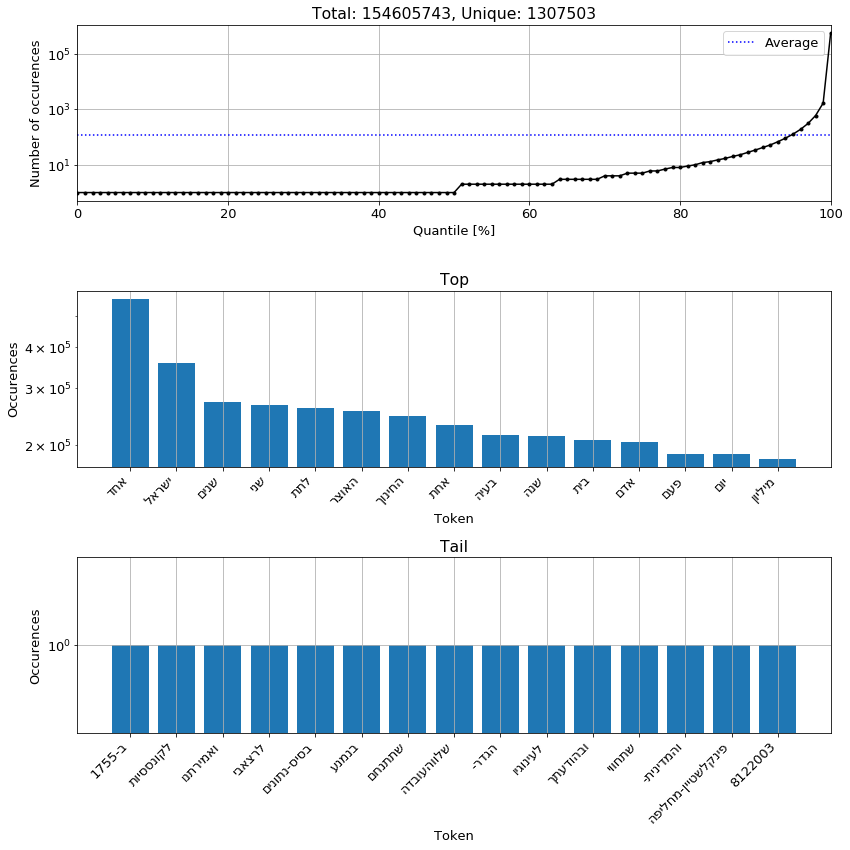

In [22]:
p.show_tokens()

In [24]:
p.tokens

In [10]:
p.profile if p.profile else ordered_counter(p.tokens)

OrderedDict([('אחד', 562971),
             ('ישראל', 356691),
             ('שנים', 271622),
             ('שני', 266047),
             ('לתת', 259782),
             ('האוצר', 253879),
             ('החינוך', 245784),
             ('אחת', 230769),
             ('בעיה', 214982),
             ('שנה', 213232),
             ('בית', 207470),
             ('אדם', 204154),
             ('פעם', 187973),
             ('יום', 187824),
             ('מיליון', 181696),
             ('מספר', 159384),
             ('רשות', 157991),
             ('העבודה', 154181),
             ('השאלה', 154086),
             ('שקל', 153339),
             ('דיון', 153286),
             ('הבעיה', 151445),
             ('שקלים', 150341),
             ('זמן', 146352),
             ('עובדים', 143351),
             ('כסף', 142957),
             ('מקום', 142212),
             ('עבודה', 142185),
             ('המשפט', 140380),
             ('מציע', 138851),
             ('הבריאות', 133696),
             ('הפנים', 128482),
 

In [27]:
df.head()

,Unnamed: 0,header,body,ID
0,0,,p_tamars\r\n\r\n2006-01-11Liraz\r\n\r\n\r\n\r\...,71333.0
1,1,סדר היום,א. קביעת מסגרת דיון להצעות להביע אי-אמון בממשל...,71333.0
2,2,"היו""ר רוני בר-און",בוקר טוב. אני מתכבד לפתוח את ישיבה מס' 74 של ו...,71333.0
3,3,זהבה גלאון,"אני מציעה ללכת על ההסדר הקבוע לדיון משולב, כמו...",71333.0
4,4,"היו""ר רוני בר-און","מה שנהגנו לעשות עד כה - המציעים, אחר-כך 20 דקו...",71333.0


#### Encoding and PCA

In [11]:
p.one_hot.head()

,---,-----------------------הכנסת,1,10,10%,100,100%,1000,10000,11,...,תשומת,תשלום,תשלומי,תשלומים,תשלם,תשמע,תשעה,תשתיות,תשתית,תתקבל
0,0,0,4,4,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,4,0,0,0,0,2,1,0,...,2,0,0,0,0,3,0,0,0,0
2,0,0,1,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,2,0,0,0,2,0,1,...,0,1,0,0,0,0,0,0,0,0
4,0,0,3,0,0,0,0,2,0,2,...,0,2,0,0,0,0,0,0,0,0


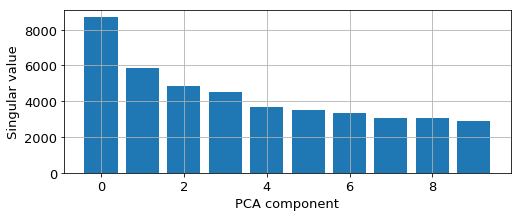

In [12]:
from sklearn.decomposition import PCA
n_comps = 10
pca = PCA(n_components=n_comps)
pca.fit(p.one_hot)
plt.figure(figsize=(8,3))
plt.bar(list(range(n_comps)), pca.singular_values_)
plt.xlabel('PCA component')
plt.ylabel('Singular value')
plt.grid()
X2D = np.matmul(p.one_hot.as_matrix(), pca.components_[:2,:].transpose())
X3D = np.matmul(p.one_hot.as_matrix(), pca.components_[:3,:].transpose())

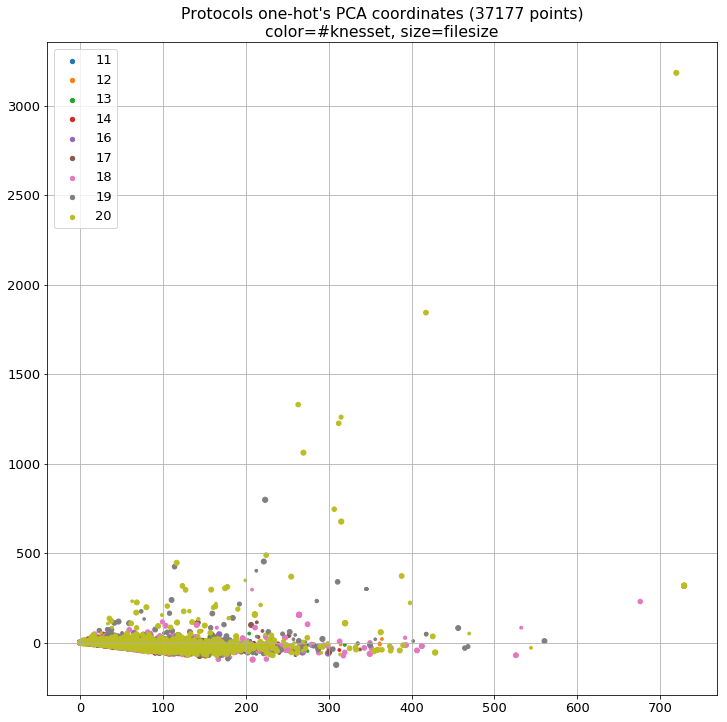

In [13]:
_, ax = plt.subplots(1,1, figsize=(12,12))

for grp in np.unique(meta[meta.ID.isin(df.ID)].KnessetNum): # TODO color by committee name rather than KnessetNum once available
    X = X2D[np.where(meta[meta.ID.isin(df.ID)].KnessetNum==grp),:].reshape(-1,2)
    sc = ax.scatter(X[:,0], X[:,1], s=np.log10(meta[meta.ID.isin(df.ID)].filesize)**2, label=int(grp))
    
ax.set_title(f"Protocols one-hot's PCA coordinates ({X2D.shape[0]:d} points)\ncolor=#knesset, size=filesize")
ax.grid()
ax.legend()

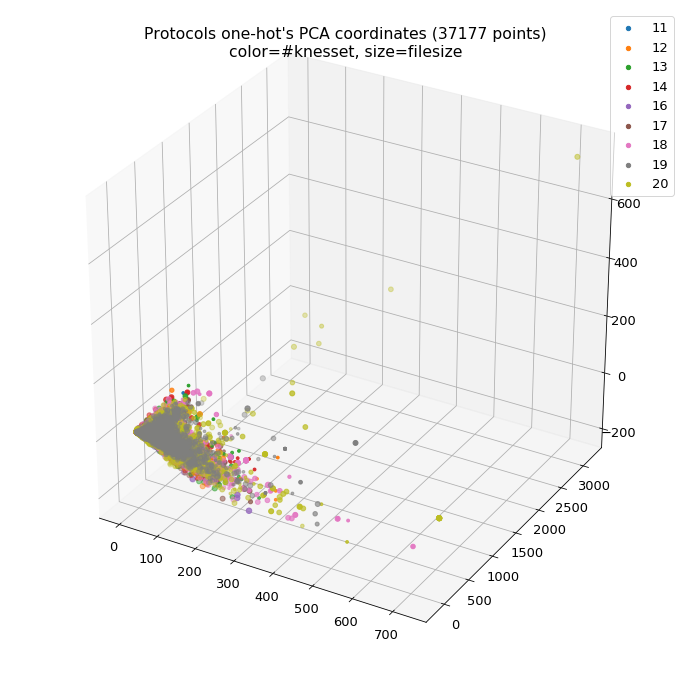

In [14]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection='3d')

for grp in np.unique(meta[meta.ID.isin(df.ID)].KnessetNum):
    X = X3D[np.where(meta[meta.ID.isin(df.ID)].KnessetNum==grp),:].reshape(-1,3)
    ax.scatter(X[:,0],X[:,1],X[:,2], label=int(grp),
               s=np.log10(meta[meta.ID.isin(df.ID)].filesize)**2)#, c=meta[meta.ID.isin(df.ID)].KnessetNum)
    
ax.set_title(f"Protocols one-hot's PCA coordinates ({X3D.shape[0]:d} points)\ncolor=#knesset, size=filesize")
ax.grid()
ax.legend()

#### Print some random protocols

In [15]:
print(p.full_protocol())

________
:
äëðñú äùîåðä òùøä

äëðñú äùîåðä òùøä

com_alex

2011-04-27Liraz



הכנסת השמונה עשרה נוסח לא מתוקן

מושב שלישי

פרוטוקול

מישיבת ועדת הכספים

יום שלישי, כ"ג באדר ב' התשע"א (29 במרץ 20121), שעה 10:00

________
סדר היום:
השוואת שכר רבני ערים חדשים

________
נכחו:


________
חברי הוועדה:
משה גפני – היו"ר

יעקב אדרי

זהבה גלאון

ניצן הורוביץ

אמנון כהן

אברהם מיכאלי

ציון פיניאן

פניה קירשנבאום

________
מוזמנים:
השר לשירותי דת יעקב מרגי

אביגדור אוחנה, מנכ"ל המשרד לשירותי דת

נתן נתנזון, חבר המועצות הדתיות בישראל, המשרד לשירותי דת

עו"ד חגי אברהמי, המשרד לשירותי דת

אילן לוין, הממונה על השכר, משרד האוצר

ניר רייס, סגן הממונה על השכר, משרד האוצר

הרב אפרים זלמנוביץ, מזכרת בתיה

הרב דוד אוחיון, הרב הראשי לאלפי מנשה

הרב חגי להב, רב הישוב בית דגן

ציון סבג, פורום רבנים חדשים

עו"ד ד"ר אביעד הכהן, יועץ משפטי לרבנים

דרור אטרי, יועץ פורום רבנים חדשים

הרב שמעון אלמליח, רב מקומי עתלית, יו"ר ארגון רבני ישראל

איתן אטיה, מרכזס השלטון המקומי, פורום ה-15

________
ייעוץ משפטי:
שגית אפיק


In [16]:
print(p.full_protocol())

________
:
com_alex

2010-08-01Liraz



הכנסת השמונה-עשרה נוסח לא מתוקן

מושב שני 

פרוטוקול מס' 293

מישיבת ועדת הכלכלה

שהתקיימה ביום שני א' באב התש"ע (12 ביולי 2010) בשעה 9:00

סדר היום: הצעת חוק להסדרת הטיפול באריזות, התש"ע-2010.

 בהשתתפות ח"כ גלעד ארדן, השר להגנת הסביבה

________
נכחו:


________
חברי הוועדה:
ישראל חסון – מ"מ היו"ר

יצחק וקנין

________
מוזמנים:
חה"כ גלעד ארדן – השר להגנת הסביבה

יוסי ענבר – מנכ"ל המשרד להגנת הסביבה

יורם הורוביץ – סמנכ"ל, המשרד להגנת הסביבה

אלעד עמיחי – עוזר מנכ"ל המשרד להגנת הסביבה

עו"ד ג'וש פדרסן – לשכה משפטית, המשרד להגנת הסביבה

עו"ד נטע דרורי – ממונה חקיקה וייעוץ, לשכה משפטית, משרד להגנת הסביבה

עו"ד דלית דרור – לשכה משפטית, המשרד להגנת הסביבה

אילן ניסים – אגף פסולת, המשרד להגנת הסביבה

יוסי חזאי – יועץ השר להגנת הסביבה

גלית פלצור – ראש אגף כלכלה וחקיקה, המשרד להגנת הסביבה

עו"ד רוני טלמור – מחלקת ייעוץ וחקיקה, משרד המשפטים

עו"ד מיכל צברי דוד – לשכה משפטית, משרד הפנים

כפיר מצוינים – רפרנט תקציבים רשויות מקומיות, משרד הפנים

מיכל שינוו

In [17]:
print(p.full_protocol())

________
:
com_alex

2011-01-02Liraz



הכנסת השמונה-עשרה נוסח לא מתוקן

מושב שלישי

פרוטוקול מס' 13





מישיבת הוועדה המשותפת של ועדת הפנים והגנת הסביבה וועדת הכלכלה

לדיון בהצעת חוק התכנון והבנייה, התש"ע-2010

‏יום חמישי, ט"ז בטבת התשע"א (‏23 בדצמבר, 2010), שעה 13:00

________
סדר היום:
1. הצעת חוק התכנון והבנייה, התש"ע-2010 – פרק ב': ועדות משנה של הוועדה המחוזית

________
נכחו:


________
חברי הוועדה:
דוד אזולאי – היו"ר

אריה ביבי – מ"מ היו"ר

אורי מקלב

________
מוזמנים:
חה"כ אחמד טיבי

עו"ד יהודה זמרת - היועץ המשפטי, משרד הפנים

עו"ד אפרת דון יחיא - הלשכה המשפטית, משרד הפנים

אפרת אפק - יועצת למנהל מינהל התכנון, משרד הפנים

קארין טלמור - יועצת, מינהל התכנון, משרד הפנים

אילנה שפרן - מרכזת הוועדה לשמירה על הסביבה החופית, ראש תחום חופים, משרד הפנים

עו"ד ארז קמיניץ - מחלקת ייעוץ וחקיקה, משרד המשפטים

ירון ימין - מתמחה, מחלקת ייעוץ וחקיקה (אזרחי), משרד המשפטים

אריאל יוצר - רפרנט בינוי, אגף התקציבים, משרד האוצר

עו"ד סגן יאיר רוזנברג - הפרקליטות הצבאית, צה"ל, משרד הביטחון

עו"ד שרית

In [18]:
print(p.full_protocol())

________
:
äëðñú äùáò-òùøä

äëðñú äùáò-òùøä

Knesset

2006-06-25Liraz



הכנסת השבע-עשרה נוסח לא מתוקן

מושב ראשון

פרוטוקול מס' 15

מישיבת ועדת הכנסת

שהתקיימה ביום שלישי, כ"ד בסיוון התשס"ו – 20 ביוני 2006 – בשעה 09:00

סדר היום: א. ערעורים על החלטת יושבת-ראש הכנסת והסגנים שלא לאשר דחיפות הצעות לסדר-היום:

של חבר הכנסת דב חנין בנושא: הפרטת בתי הסוהר

של חבר הכנסת מאיר פרוש בנושא: יחס מדינות אירופה לתוכנית ההתכנסות בעקבות ביקור ראש הממשלה

ב. בקשות חברי הכנסת להקדמת הדיון בהצעות החוק הבאות, לפני הקריאה הטרומית:

1. הצעת חוק בתי המשפט (תיקון – כללי אתיקה לשופטים), התשס"ו-2006 (פ/630/17), הצעת חבר הכנסת מנחם בן-ששון

2. הצעת חוק שיפוט בתי דין רבניים (נישואין וגירושין)(תיקון – סמכות שיפוט בהסכמה בעניין אזרחי וסמכות נלווית), התשס"ו-2006 (פ/216/17), הצעת חבר הכנסת דוד אזולאי

________
נכחו:
חברי הוועדה: יעקב מרגי – מ"מ היו"ר

 קולט אביטל

 דוד אזולאי

 אורי אריאל

 אליהו גבאי

 יצחק גלנטי

 אסתרינה טרטמן

 אביגדור יצחקי

 אפרים סנה

 גדעון סער

 מנחם בן-ששון

 יצחק זיו

 דב חנין

 מרינה סול